<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



# Access Popular LLMs via Google-Colab-AI Without an API Key

Users with Colab's paid plans have free access to most popular LLMs via google-colab-ai Python library. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).

In [ ]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


Using device: cpu
Train Epoch 1/20, avg loss 0.4717
Train Epoch 2/20, avg loss 0.4723
Train Epoch 3/20, avg loss 0.4708
Train Epoch 4/20, avg loss 0.4719
Train Epoch 5/20, avg loss 0.4924
Train Epoch 6/20, avg loss 0.4719
Train Epoch 7/20, avg loss 0.4729
Train Epoch 8/20, avg loss 0.4711
Train Epoch 9/20, avg loss 0.4701
Train Epoch 10/20, avg loss 0.4715
Train Epoch 11/20, avg loss 0.4713
Train Epoch 12/20, avg loss 0.4703
Train Epoch 13/20, avg loss 0.4715
Train Epoch 14/20, avg loss 0.4742
Train Epoch 15/20, avg loss 0.4693
Train Epoch 16/20, avg loss 0.4729
Train Epoch 17/20, avg loss 0.4710
Train Epoch 18/20, avg loss 0.4700
Train Epoch 19/20, avg loss 0.4701
Train Epoch 20/20, avg loss 0.4703


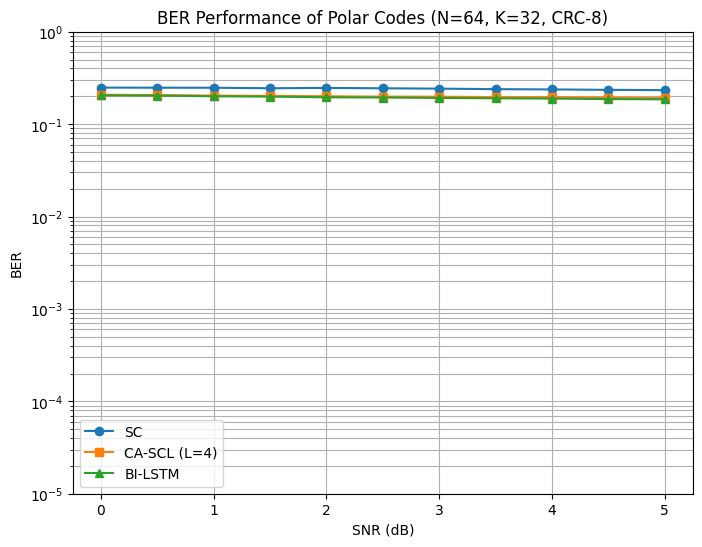

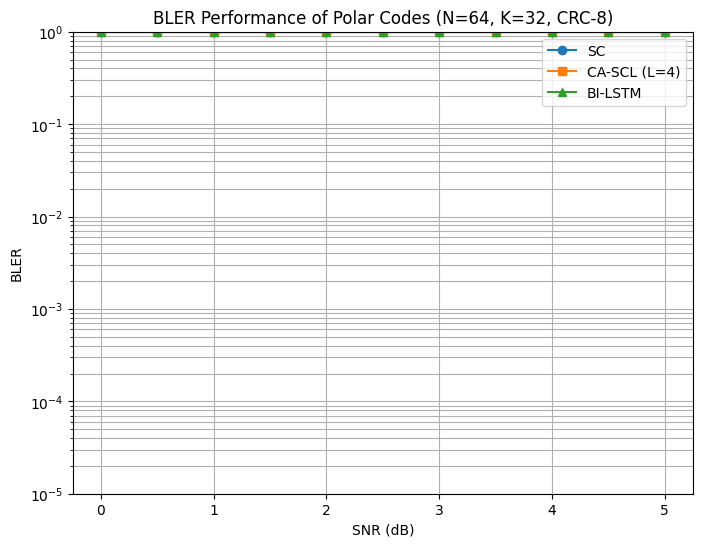

Simulation complete. BER/BLER plots saved as 'ber_plot.png' and 'bler_plot.png'. Results saved in 'results.csv'.


In [22]:
# Polar Codes with BI-LSTM Decoder
# N=64, K=32, CRC=8, Arikan sequence
# For Kinston University International conference, November 2025

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import csv
import math

# Config
N = 64
K = 32
CRC_LEN = 8
RATE = K / N
SNR_RANGE_DB = np.arange(0, 5.5, 0.5)
NUM_FRAMES = 5000  # increase for final run

HIDDEN_SIZE = 64
NUM_LAYERS = 2
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CRC-8 Functions
CRC_POLY = 0x07

def crc8_encode(bits):
    data = bits.copy()
    crc = 0
    for b in data:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    crc_bits = [(crc >> i) & 1 for i in reversed(range(8))]
    return np.concatenate([data, crc_bits])

def crc8_check(bits):
    crc = 0
    for b in bits:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    return crc == 0

# Arikan's Reliability Sequence for N=64 (3GPP 38.212)
ARIKAN_SEQ_64 = [
    0, 1, 2, 4, 8, 16, 32, 3,
    5, 9, 17, 33, 6, 10, 18, 34,
    12, 24, 48, 7, 11, 19, 35, 13,
    25, 49, 14, 26, 50, 28, 36, 52,
    15, 27, 51, 29, 37, 53, 30, 38,
    54, 31, 39, 55, 40, 56, 41, 57,
    42, 58, 43, 59, 44, 60, 45, 61,
    46, 62, 47, 63
]

# Polar Code Generator
class PolarCode:
    def __init__(self, N, K, crc_len, reliab_seq):
        self.N = N
        self.K = K
        self.crc_len = crc_len
        self.info_len = K - crc_len
        self.reliab_seq = reliab_seq
        self.frozen_bits = np.ones(N, dtype=bool)  # True=frozen
        self.info_positions = np.sort(reliab_seq[:K])
        self.frozen_bits[self.info_positions] = False

    def encode(self, u):
        u_crc = crc8_encode(u)
        x = np.zeros(self.N, dtype=int)
        x[self.info_positions] = u_crc[:self.K]  # Only first K bits with CRC
        n = self.N
        stage = 1
        while stage < n:
            for i in range(0, n, 2*stage):
                for j in range(stage):
                    x[i+j] ^= x[i+j+stage]
            stage *= 2
        return x

polar = PolarCode(N, K, CRC_LEN, ARIKAN_SEQ_64)

# Modulation and channel

def bpsk_mod(bits):
    return 1 - 2*bits
def bpsk_to_llr(y, snr_db):
    snr_linear = 10**(snr_db / 10)
    sigma2 = 1 / (2 * RATE * snr_linear)
    return 2 * y / sigma2
def simulate_awgn_for_frames(s_frames, snr_db):
    R = RATE
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1.0 / (2.0 * R * snr_linear)
    sigma = math.sqrt(sigma2)
    y = s_frames + sigma * np.random.randn(*s_frames.shape)
    llr = 2.0 * y / sigma2
    return y, llr, sigma2

# SC decoder
def sc_decode(llr, frozen_mask):
    N = len(llr)

    def recurse(llr_sub, mask_sub):
        n = len(llr_sub)
        if n == 1:
            if mask_sub[0]:
                return np.array([0], dtype=int)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=int)
        half = n // 2
        llr_left = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i+half]
            llr_left[i] = np.sign(a)*np.sign(b)*min(abs(a), abs(b))
        mask_left = mask_sub[:half]
        u_hat_left = recurse(llr_left, mask_left)
        llr_right = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i+half]
            llr_right[i] = b + ((1 - 2*u_hat_left[i])*a)
        mask_right = mask_sub[half:]
        u_hat_right = recurse(llr_right, mask_right)
        u = np.zeros(n, dtype=int)
        for i in range(half):
            u[i] = u_hat_left[i] ^ u_hat_right[i]
            u[i+half] = u_hat_right[i]
        return u

    u_hat = recurse(llr, frozen_mask)
    x = u_hat.copy()
    stage = 1
    while stage < N:
        for i in range(0, N, 2*stage):
            for j in range(stage):
                x[i+j+stage] ^= x[i+j]
        stage *= 2
    return x, u_hat

# SCL decoder (simplified)
def scl_decode(llr, frozen_mask, list_size=8):
    N = len(llr)
    paths = [{'u': np.zeros(0, dtype=int), 'metric': 0.0}]
    for phi in range(N):
        new_paths = []
        is_frozen = frozen_mask[phi]

        def compute_llr_for_prefix(prefix_bits):
            return llr[phi]  # Simplified approx

        for path in paths:
            prefix = path['u']
            base_metric = path['metric']
            if is_frozen:
                bit = 0
                l = compute_llr_for_prefix(prefix)
                pen = abs(l) if (l < 0) else 0.0
                new_u = np.concatenate([prefix, np.array([bit], dtype=int)])
                new_paths.append({'u': new_u, 'metric': base_metric + pen})
            else:
                for bit in (0, 1):
                    l = compute_llr_for_prefix(prefix)
                    pen = 0.0
                    if (l >= 0 and bit == 1) or (l < 0 and bit == 0):
                        pen += abs(l)
                    new_u = np.concatenate([prefix, np.array([bit], dtype=int)])
                    new_paths.append({'u': new_u, 'metric': base_metric + pen})

        new_paths = sorted(new_paths, key=lambda p: p['metric'])
        paths = new_paths[:list_size]

    candidates = []
    for p in paths:
        u_vec = p['u']
        info_vec = u_vec[polar.info_positions]
        if crc8_check(info_vec):
            candidates.append((p['metric'], info_vec))

    if candidates:
        candidates = sorted(candidates, key=lambda x: x[0])
        chosen_info = candidates[0][1]
        x = np.zeros(N, dtype=int)
        x[polar.info_positions] = chosen_info
        x_c = x.copy()
        stage = 1
        while stage < N:
            for i in range(0, N, 2*stage):
                for j in range(stage):
                    x_c[i+j+stage] ^= x_c[i+j]
            stage *= 2
        return x_c, chosen_info
    else:
        best = paths[0]
        info_vec = best['u'][polar.info_positions]
        x = np.zeros(N, dtype=int)
        x[polar.info_positions] = info_vec
        x_c = x.copy()
        stage = 1
        while stage < N:
            for i in range(0, N, 2*stage):
                for j in range(stage):
                    x_c[i+j+stage] ^= x_c[i+j]
            stage *= 2
        return x_c, info_vec

# BI-LSTM Decoder
class BiLSTMDecoder(nn.Module):
    def __init__(self, input_len, hidden_size=64, num_layers=2, output_len=None):
        super(BiLSTMDecoder, self).__init__()
        self.input_len = input_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_len = output_len if output_len is not None else input_len
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_len)
        )

    def forward(self, x):
        b, s = x.shape
        x_ = x.unsqueeze(-1)
        out, _ = self.lstm(x_)
        pooled = out.mean(dim=1)
        logits = self.fc(pooled)
        return logits

# Modulation helper functions
def bits_to_bpsk(bits):
    return 1 - 2 * bits

def simulate_awgn(x, snr_db):
    snr_linear = 10**(snr_db / 10)
    sigma = np.sqrt(1 / (2 * RATE * snr_linear))
    noise = sigma * np.random.randn(*x.shape)
    return x + noise

def bpsk_to_llr(y, snr_db):
    snr_linear = 10**(snr_db / 10)
    sigma2 = 1 / (2 * RATE * snr_linear)
    return 2 * y / sigma2
######################Latest for list size
def train_bilstm(model, optimizer, criterion, epochs, batch_size, snr_db, lr=1e-3):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        losses = []
        steps = 200 if batch_size <= 64 else 100
        for step in range(steps):
            s_batch = []
            target_batch = []
            # Random SNR for this batch between snr_db and snr_db + 2 dB
            train_snr_db = np.random.uniform(snr_db, snr_db + 2)
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)
                u_crc = crc8_encode(u_msg)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                s_batch.append(s)
                target_batch.append(u_crc.astype(np.float32))
            s_batch = np.stack(s_batch, axis=0)
            _, llr_batch, sigma2 = simulate_awgn_for_frames(s_batch, train_snr_db)
            inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)

            logits = model(inp)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
            loss = criterion(outputs, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"Train Epoch {epoch+1}/{epochs}, avg loss {np.mean(losses):.4f}")
    return model

    # ----- BI-LSTM decoder function for evaluation -----
def bilstm_decoder_func(llr):
    model.eval()
    with torch.no_grad():
        inp = torch.tensor(llr, dtype=torch.float32).unsqueeze(0).to(device)  # (1, N)
        out = model(inp)  # (1, K)
        probs = torch.sigmoid(out).cpu().numpy()[0]
        return (probs >= 0.5).astype(int)

# ----- Evaluate decoders over SNR range -----
ber_sc, bler_sc = evaluate_decoder(lambda llr: sc_decode(llr, polar.frozen_bits)[1], SNR_RANGE_DB, NUM_FRAMES)
ber_scl4, bler_scl4 = evaluate_decoder(lambda llr: scl_decode(llr, polar.frozen_bits, list_size=4)[1], SNR_RANGE_DB, NUM_FRAMES)

# Train BI-LSTM decoder with randomized SNR between 2 and 4 dB
train_bilstm(model, optimizer, criterion, EPOCHS, BATCH_SIZE, snr_db=2.0, lr=LEARNING_RATE)

# Evaluate BI-LSTM decoder
ber_nn, bler_nn = evaluate_decoder(bilstm_decoder_func, SNR_RANGE_DB, NUM_FRAMES)

# ----- Plot BER -----
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, ber_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, ber_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, ber_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.ylim(1e-5, 1)
plt.grid(True, which='both')
plt.legend()
plt.title('BER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.savefig("ber_plot.png", dpi=300)
plt.show()

# ----- Plot BLER -----
plt.figure(figsize=(8,6))
plt.semilogy(SNR_RANGE_DB, bler_sc, 'o-', label='SC')
plt.semilogy(SNR_RANGE_DB, bler_scl4, 's-', label='CA-SCL (L=4)')
plt.semilogy(SNR_RANGE_DB, bler_nn, '^-', label='BI-LSTM')
plt.xlabel('SNR (dB)')
plt.ylabel('BLER')
plt.ylim(1e-5, 1)
plt.grid(True, which='both')
plt.legend()
plt.title('BLER Performance of Polar Codes (N=64, K=32, CRC-8)')
plt.savefig("bler_plot.png", dpi=300)
plt.show()

# ----- Save results to CSV -----
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['SNR(dB)', 'BER_SC', 'BER_SCL4', 'BER_BILSTM', 'BLER_SC', 'BLER_SCL4', 'BLER_BILSTM'])
    for i, snr_db in enumerate(SNR_RANGE_DB):
        writer.writerow([snr_db, ber_sc[i], ber_scl4[i], ber_nn[i], bler_sc[i], bler_scl4[i], bler_nn[i]])

print("Simulation complete. BER/BLER plots saved as 'ber_plot.png' and 'bler_plot.png'. Results saved in 'results.csv'.")


Using device: cpu
Training BI-LSTM decoder...
Epoch 1/20, Loss: 0.6885
Epoch 2/20, Loss: 0.6779
Epoch 3/20, Loss: 0.6677
Epoch 4/20, Loss: 0.6488
Epoch 5/20, Loss: 0.6218
Epoch 6/20, Loss: 0.5903
Epoch 7/20, Loss: 0.5632
Epoch 8/20, Loss: 0.5414
Epoch 9/20, Loss: 0.5211
Epoch 10/20, Loss: 0.5101
Epoch 11/20, Loss: 0.5053
Epoch 12/20, Loss: 0.5011
Epoch 13/20, Loss: 0.4996
Epoch 14/20, Loss: 0.5012
Epoch 15/20, Loss: 0.4983
Epoch 16/20, Loss: 0.4971
Epoch 17/20, Loss: 0.4978
Epoch 18/20, Loss: 0.4977
Epoch 19/20, Loss: 0.4958
Epoch 20/20, Loss: 0.4938
Evaluating SC decoder...
SNR 0.0 dB: BER = 4.91300e-01, BLER = 1.00000e+00
SNR 0.5 dB: BER = 4.88325e-01, BLER = 1.00000e+00
SNR 1.0 dB: BER = 4.84194e-01, BLER = 1.00000e+00
SNR 1.5 dB: BER = 4.76569e-01, BLER = 1.00000e+00
SNR 2.0 dB: BER = 4.72769e-01, BLER = 1.00000e+00
SNR 2.5 dB: BER = 4.62406e-01, BLER = 1.00000e+00
SNR 3.0 dB: BER = 4.53213e-01, BLER = 1.00000e+00
SNR 3.5 dB: BER = 4.43431e-01, BLER = 1.00000e+00
SNR 4.0 dB: BER = 

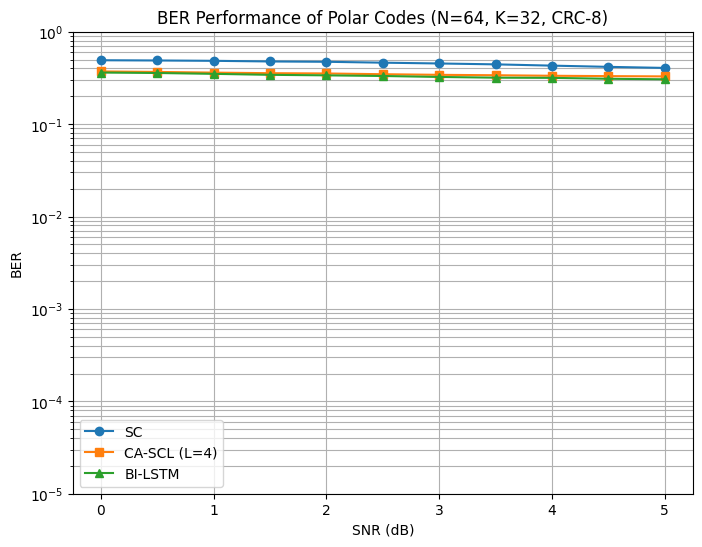

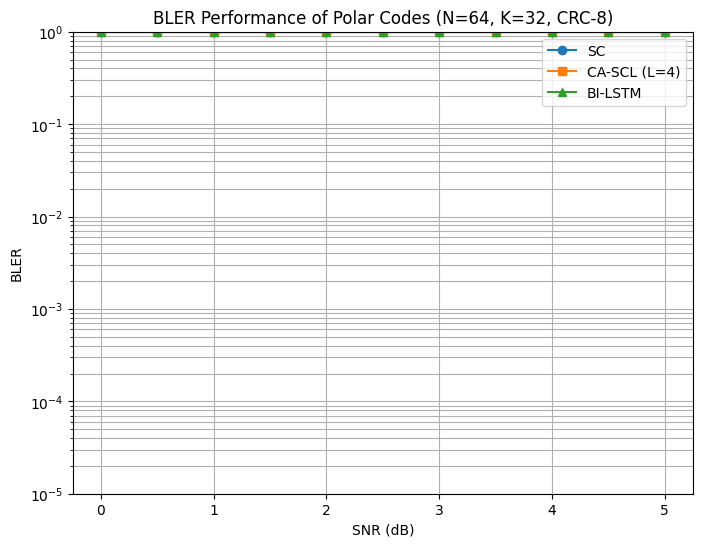

Simulation complete. Plots saved and results.csv written.


In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import csv

# ----- Config -----
N = 64
K = 32
CRC_LEN = 8
RATE = K / N
SNR_RANGE_DB = np.arange(0, 5.5, 0.5)
NUM_FRAMES = 5000  # Increase for final runs; keep low for testing

HIDDEN_SIZE = 64
NUM_LAYERS = 2
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- CRC-8 functions -----
CRC_POLY = 0x07

def crc8_encode(bits):
    data = bits.copy()
    crc = 0
    for b in data:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    crc_bits = [(crc >> i) & 1 for i in reversed(range(8))]
    return np.concatenate([data, crc_bits])

def crc8_check(bits):
    crc = 0
    for b in bits:
        crc ^= b << 7
        for _ in range(8):
            if crc & 0x80:
                crc = ((crc << 1) ^ CRC_POLY) & 0xFF
            else:
                crc = (crc << 1) & 0xFF
    return crc == 0

# ----- Arikan's reliability sequence for N=64 -----
ARIKAN_SEQ_64 = [
    0, 1, 2, 4, 8, 16, 32, 3,
    5, 9, 17, 33, 6, 10, 18, 34,
    12, 24, 48, 7, 11, 19, 35, 13,
    25, 49, 14, 26, 50, 28, 36, 52,
    15, 27, 51, 29, 37, 53, 30, 38,
    54, 31, 39, 55, 40, 56, 41, 57,
    42, 58, 43, 59, 44, 60, 45, 61,
    46, 62, 47, 63
]

# ----- Polar Code class -----
class PolarCode:
    def __init__(self, N, K, crc_len, reliab_seq):
        self.N = N
        self.K = K
        self.crc_len = crc_len
        self.info_len = K - crc_len
        self.reliab_seq = reliab_seq
        self.frozen_bits = np.ones(N, dtype=bool)
        self.info_positions = np.sort(reliab_seq[:K])
        self.frozen_bits[self.info_positions] = False

    def encode(self, u):
        u_crc = crc8_encode(u)
        x = np.zeros(self.N, dtype=int)
        x[self.info_positions] = u_crc[:self.K]
        n = self.N
        stage = 1
        while stage < n:
            for i in range(0, n, 2*stage):
                for j in range(stage):
                    x[i+j] ^= x[i+j+stage]
            stage *= 2
        return x

polar = PolarCode(N, K, CRC_LEN, ARIKAN_SEQ_64)

# ----- Modulation & Channel -----
def bpsk_mod(bits):
    return 1 - 2*bits

def simulate_awgn(x, snr_db):
    snr_linear = 10**(snr_db / 10)
    sigma = np.sqrt(1 / (2 * RATE * snr_linear))
    noise = sigma * np.random.randn(*x.shape)
    return x + noise

def bpsk_to_llr(y, snr_db):
    snr_linear = 10**(snr_db / 10)
    sigma2 = 1 / (2 * RATE * snr_linear)
    return 2 * y / sigma2

# ----- SC Decoder -----
def sc_decode(llr, frozen_mask):
    N = len(llr)

    def recurse(llr_sub, mask_sub):
        n = len(llr_sub)
        if n == 1:
            if mask_sub[0]:
                return np.array([0], dtype=int)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=int)
        half = n // 2
        llr_left = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i+half]
            llr_left[i] = np.sign(a)*np.sign(b)*min(abs(a), abs(b))
        mask_left = mask_sub[:half]
        u_hat_left = recurse(llr_left, mask_left)
        llr_right = np.zeros(half)
        for i in range(half):
            a = llr_sub[i]
            b = llr_sub[i+half]
            llr_right[i] = b + ((1 - 2*u_hat_left[i])*a)
        mask_right = mask_sub[half:]
        u_hat_right = recurse(llr_right, mask_right)
        u = np.zeros(n, dtype=int)
        for i in range(half):
            u[i] = u_hat_left[i] ^ u_hat_right[i]
            u[i+half] = u_hat_right[i]
        return u

    u_hat = recurse(llr, frozen_mask)
    return u_hat

# ----- Simplified SCL Decoder (list size=4) -----
def scl_decode(llr, frozen_mask, list_size=4):
    N = len(llr)
    paths = [{'u': np.zeros(0, dtype=int), 'metric': 0.0}]
    for phi in range(N):
        new_paths = []
        is_frozen = frozen_mask[phi]

        for path in paths:
            prefix = path['u']
            base_metric = path['metric']

            if is_frozen:
                bit = 0
                pen = abs(llr[phi]) if llr[phi] < 0 else 0.0
                new_u = np.concatenate([prefix, np.array([bit], dtype=int)])
                new_paths.append({'u': new_u, 'metric': base_metric + pen})
            else:
                for bit in (0, 1):
                    pen = 0.0
                    if (llr[phi] >= 0 and bit == 1) or (llr[phi] < 0 and bit == 0):
                        pen += abs(llr[phi])
                    new_u = np.concatenate([prefix, np.array([bit], dtype=int)])
                    new_paths.append({'u': new_u, 'metric': base_metric + pen})

        new_paths = sorted(new_paths, key=lambda p: p['metric'])
        paths = new_paths[:list_size]

    candidates = []
    for p in paths:
        u_vec = p['u']
        info_vec = u_vec[polar.info_positions]
        if crc8_check(info_vec):
            candidates.append((p['metric'], info_vec))

    if candidates:
        candidates = sorted(candidates, key=lambda x: x[0])
        chosen_info = candidates[0][1]
    else:
        best = paths[0]
        chosen_info = best['u'][polar.info_positions]

    return chosen_info

# ----- BI-LSTM Decoder -----
class BiLSTMDecoder(nn.Module):
    def __init__(self, input_len, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_len=K):
        super(BiLSTMDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, output_len)
        )

    def forward(self, x):
        # x shape: (batch, seq_len)
        x_ = x.unsqueeze(-1)  # (batch, seq_len, 1)
        out, _ = self.lstm(x_)
        pooled = out.mean(dim=1)  # (batch, 2*hidden_size)
        logits = self.fc(pooled)  # (batch, output_len)
        return logits

# ----- Training function for BI-LSTM -----
def train_bilstm(model, optimizer, criterion, epochs, batch_size, snr_db, lr=LEARNING_RATE):
    model.train()
    for epoch in range(epochs):
        losses = []
        steps = 200  # arbitrary steps per epoch
        for _ in range(steps):
            s_batch = []
            target_batch = []
            train_snr_db = np.random.uniform(snr_db, snr_db + 2)  # randomize SNR in [snr_db, snr_db+2]
            for _ in range(batch_size):
                u_msg = np.random.randint(0, 2, polar.info_len)
                u_crc = crc8_encode(u_msg)
                x = polar.encode(u_msg)
                s = bpsk_mod(x)
                s_batch.append(s)
                target_batch.append(u_crc.astype(np.float32))
            s_batch = np.stack(s_batch, axis=0)
            _, llr_batch, _ = simulate_awgn_for_frames(s_batch, train_snr_db)
            inp = torch.tensor(llr_batch, dtype=torch.float32, device=device)
            tgt = torch.tensor(np.stack(target_batch), dtype=torch.float32, device=device)

            logits = model(inp)
            outputs = torch.sigmoid(logits)
            outputs = torch.clamp(outputs, 1e-7, 1 - 1e-7)
            loss = criterion(outputs, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")

# ----- AWGN simulation for multiple frames (helper) -----
def simulate_awgn_for_frames(s_frames, snr_db):
    R = RATE
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1.0 / (2.0 * R * snr_linear)
    sigma = math.sqrt(sigma2)
    y = s_frames + sigma * np.random.randn(*s_frames.shape)
    llr = 2.0 * y / sigma2
    return y, llr, sigma2

# ----- BI-LSTM decoder wrapper -----
def bilstm_decoder_func(llr):
    model.eval()
    with torch.no_grad():
        inp = torch.tensor(llr, dtype=torch.float32).unsqueeze(0).to(device)  # (1, N)
        out = model(inp)  # (1, K)
        probs = torch.sigmoid(out).cpu().numpy()[0]
        return (probs >= 0.5).astype(int)

# ----- Evaluate a decoder over the SNR range -----Latest
def evaluate_decoder(decoder_func, snr_range_db, num_frames):
    ber = []
    bler = []
    for snr_db in snr_range_db:
        bit_errors = 0
        block_errors = 0
        total_bits = 0
        for _ in range(num_frames):
            # Generate random message
            u_msg = np.random.randint(0, 2, polar.info_len)
            u_crc = crc8_encode(u_msg)

            # Encode
            x = polar.encode(u_msg)

            # Modulate
            s = bpsk_mod(x)

            # Pass through AWGN channel
            y = simulate_awgn(s, snr_db)

            # Compute LLRs
            llr = bpsk_to_llr(y, snr_db)

            # Decode
            u_hat = decoder_func(llr)

            # If decoder returns full codeword length N, extract info bits
            if len(u_hat) == N:
                u_hat_info = u_hat[polar.info_positions]
            else:
                u_hat_info = u_hat

            # Count bit errors and block errors
            bit_errors += np.sum(u_hat_info != u_crc)
            total_bits += len(u_crc)
            if not np.array_equal(u_hat_info, u_crc):
                block_errors += 1

        ber.append(bit_errors / total_bits)
        bler.append(block_errors / num_frames)
        print(f"SNR {snr_db} dB: BER = {ber[-1]:.5e}, BLER = {bler[-1]:.5e}")

    return np.array(ber), np.array(bler)
##################################################################


# ----- Main script -----
if __name__ == "__main__":
    # Create BI-LSTM model, optimizer, loss
    model = BiLSTMDecoder(N, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_len=K).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCELoss()

    # Train BI-LSTM decoder at SNR=2 dB (randomized in train function)
    print("Training BI-LSTM decoder...")
    train_bilstm(model, optimizer, criterion, EPOCHS, BATCH_SIZE, snr_db=2.0)

    # Evaluate all decoders
    print("Evaluating SC decoder...")
    ber_sc, bler_sc = evaluate_decoder(lambda llr: sc_decode(llr, polar.frozen_bits), SNR_RANGE_DB, NUM_FRAMES)
    print("Evaluating CA-SCL decoder (L=4)...")
    ber_scl4, bler_scl4 = evaluate_decoder(lambda llr: scl_decode(llr, polar.frozen_bits, list_size=4), SNR_RANGE_DB, NUM_FRAMES)
    print("Evaluating BI-LSTM decoder...")
    ber_nn, bler_nn = evaluate_decoder(bilstm_decoder_func, SNR_RANGE_DB, NUM_FRAMES)

    # ----- Plot BER -----
    plt.figure(figsize=(8,6))
    plt.semilogy(SNR_RANGE_DB, ber_sc, 'o-', label='SC')
    plt.semilogy(SNR_RANGE_DB, ber_scl4, 's-', label='CA-SCL (L=4)')
    plt.semilogy(SNR_RANGE_DB, ber_nn, '^-', label='BI-LSTM')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.ylim(1e-5, 1)
    plt.grid(True, which='both')
    plt.legend()
    plt.title('BER Performance of Polar Codes (N=64, K=32, CRC-8)')
    plt.savefig("ber_plot.png", dpi=300)
    plt.show()

    # ----- Plot BLER -----
    plt.figure(figsize=(8,6))
    plt.semilogy(SNR_RANGE_DB, bler_sc, 'o-', label='SC')
    plt.semilogy(SNR_RANGE_DB, bler_scl4, 's-', label='CA-SCL (L=4)')
    plt.semilogy(SNR_RANGE_DB, bler_nn, '^-', label='BI-LSTM')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER')
    plt.ylim(1e-5, 1)
    plt.grid(True, which='both')
    plt.legend()
    plt.title('BLER Performance of Polar Codes (N=64, K=32, CRC-8)')
    plt.savefig("bler_plot.png", dpi=300)
    plt.show()

    # ----- Save results to CSV -----
    with open('results.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['SNR(dB)', 'BER_SC', 'BER_SCL4', 'BER_BILSTM', 'BLER_SC', 'BLER_SCL4', 'BLER_BILSTM'])
        for i, snr_db in enumerate(SNR_RANGE_DB):
            writer.writerow([snr_db, ber_sc[i], ber_scl4[i], ber_nn[i], bler_sc[i], bler_scl4[i], bler_nn[i]])

    print("Simulation complete. Plots saved and results.csv written.")